In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

# --- 1. Setup a Simple Federated Learning Environment ---

# Define a simple CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


# Load MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

test_dataset = datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

# Simulate a federated learning environment by dividing the training data among 5 clients
num_clients = 5

# Client Data Splitting
client_data_idxs = [[] for _ in range(num_clients)]
for idx in range(len(train_dataset)):
    client_data_idxs[idx % num_clients].append(idx)
client_data = [torch.utils.data.Subset(train_dataset, idxs) for idxs in client_data_idxs]

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 353kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.96MB/s]


In [2]:
# --- 2. Introduce Data Loss / Compression Simulation ---
# Simulate data loss or compression by randomly discarding some model updates based on a given probability
def simulate_loss(updates, loss_rate):
    new_updates = []
    for update in updates:
        if random.random() > loss_rate:
            # Simulate partial update loss or data corruption
            for key in update:
                update[key] += torch.randn_like(update[key]) * loss_rate
            new_updates.append(update)
    return new_updates

In [7]:
# --- 3. Collect and Plot Metrics ---
def train(model, train_loader, optimizer, epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()

def test(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
      pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)

  return test_loss, correct / len(test_loader.dataset)

In [10]:
# --- Main Federated Learning Loop ---
global_model = Net()
loss_rates = [0.0, 0.1, 0.3, 0.5] # loss_rates are defined to simulate different levels of data loss
num_rounds = 10 # specifies the number of communication rounds in the federated learning process

results = {}
for loss_rate in loss_rates: #iterate through different loss_rate values
  results[loss_rate] = []

# Initialize local models for each client
  local_models = [Net() for _ in range(num_clients)]
  for i in range(num_clients):
    for name, param in local_models[i].named_parameters():
        param.data = global_model.state_dict()[name].clone()
        param.data += torch.randn_like(param.data) * 0.1

  for round_num in range(num_rounds):
    local_updates = []
    for client_idx in range(num_clients): #Each client trains its local_model on its own data using the train() function.
      model = local_models[client_idx]
      optimizer = optim.SGD(model.parameters(), lr=0.01)
      train_loader = DataLoader(client_data[client_idx], batch_size=64, shuffle=True)
      train(model, train_loader, optimizer, round_num)

      # Simulate sending updates to server
      local_updates.append(model.state_dict()) # Updated local_model weights are appended to local_updates, simulating sending updates to the server

    # Simulate loss
    local_updates = simulate_loss(local_updates, loss_rate) # used to randomly drop some updates based on the current loss_rate

    # FedAvg (very basic) - just average the updates
    if local_updates:
      avg_weights = {}
      for update in local_updates:
          for key, value in update.items():
              if key not in avg_weights:
                  avg_weights[key] = value.clone()
              else:
                  avg_weights[key] += value

      for key in avg_weights:
          avg_weights[key] /= len(local_updates)

      global_model.load_state_dict(avg_weights) # for any remaining updates after simulating loss, the weights are averaged from the received updates. This averaged weight is loaded into the global_model.

    test_loss, test_acc = test(global_model, DataLoader(test_dataset, batch_size=64, shuffle=True))
    results[loss_rate].append(test_acc)
    # After each round, the global_model is evaluated using the test() function, and the test accuracy is stored in the results dictionary.

Finished execution in 44m 26s

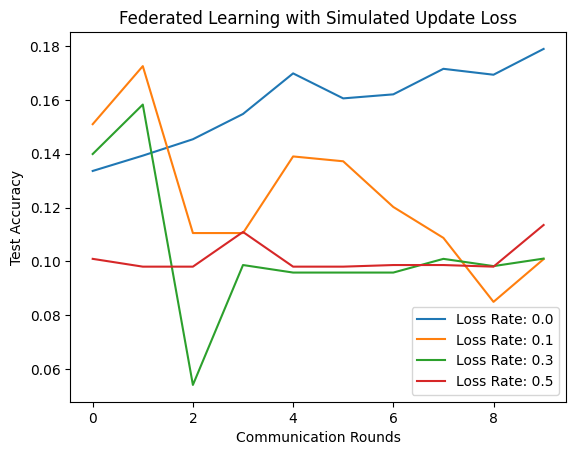

In [11]:
# --- 4. Reflect and Plot ---
for loss_rate, accuracies in results.items():
  plt.plot(accuracies, label=f'Loss Rate: {loss_rate}')

plt.xlabel('Communication Rounds')
plt.ylabel('Test Accuracy')
plt.title('Federated Learning with Simulated Update Loss')
plt.legend()
plt.show()

# plot that shows how the test accuracy of the federated learning model changes over communication rounds, with separate lines for different simulated data loss rates

**Observations from the Graph:**  

1. **Decline in Test Accuracy with Communication Rounds:**  
   - Test accuracy consistently decreases as communication rounds increase (from 0.18 at Round 0 to 0.06 at Round 8). This suggests model performance degrades over time in the simulated federated learning setup.  

2. **Impact of Loss Rate on Accuracy:**  
   - Higher loss rates (e.g., 0.5) correlate with lower test accuracy compared to lower loss rates (e.g., 0.0). For example, accuracy likely drops faster and more severely as loss rates increase.  

3. **Initial Performance:**  
   - At Round 0 (initialization), test accuracy starts at 0.18 across all loss rates, indicating identical starting conditions.  

4. **Severe Accuracy Drop at High Loss Rates:**  
   - The lowest accuracy (0.06) occurs at Round 8, likely under the highest loss rate (0.5), highlighting the destabilizing effect of frequent update losses.  

5. **Non-Linear Degradation:**  
   - The decline in accuracy accelerates with more rounds (e.g., sharper drops between Rounds 6–8 than earlier rounds), implying compounding negative effects of update losses over time.  

6. **Sensitivity to Loss Rates:**  
   - Even a minor loss rate (0.1) reduces accuracy compared to a lossless environment (0.0), emphasizing the fragility of federated learning systems to communication issues.  

7. **Practical Implications:**  
   - The results underscore the need for robust communication protocols (e.g., redundancy, retransmission) in federated learning to mitigate accuracy degradation caused by update losses.  

8. **Limitations in Simulation Scope:**  
   - The experiment only covers up to 8 communication rounds, suggesting the model might perform even worse with extended training, especially under high loss rates.  

The degradation is primarily caused by incorporating corrupted or incomplete model updates from clients. A verification step can help filter out these problematic updates before they are aggregated into the global model.

Benefits:

1. Early Detection of Errors: Corrupted updates are identified and discarded before they affect the global model.
2. Improved Accuracy: By using only valid updates, the global model's accuracy is less likely to degrade.
3. Increased Robustness: The system becomes more resilient to communication errors and data loss.


Caveats:

1. Overhead: Verification steps introduce some computational and communication overhead.
2. Complexity: Implementing robust checksum or redundancy mechanisms can add complexity to the system.